In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
!pip install -U /kaggle/input/orkatzfdata/torch-1.5.0+cu101-cp37-cp37m-linux_x86_64.whl /kaggle/input/orkatzfdata/torchvision-0.6.0+cu101-cp37-cp37m-linux_x86_64.whl

Processing /kaggle/input/orkatzfdata/torch-1.5.0+cu101-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/orkatzfdata/torchvision-0.6.0+cu101-cp37-cp37m-linux_x86_64.whl
ERROR: allennlp 0.9.0 has requirement spacy<2.2,>=2.1.0, but you'll have spacy 2.2.3 which is incompatible.
  Attempting uninstall: torch
    Found existing installation: torch 1.5.0
    Uninstalling torch-1.5.0:
      Successfully uninstalled torch-1.5.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0a0+82fd1c8
    Uninstalling torchvision-0.6.0a0+82fd1c8:
      Successfully uninstalled torchvision-0.6.0a0+82fd1c8


In [3]:
!pip install '/kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl'
!pip install /kaggle/input/orkatzfdata/yacs-0.1.7-py3-none-any.whl
!mkdir fvcore
!cp -R '/kaggle/input/orkatzfdata/fvcore-0.1.dev200407/fvcore-0.1.dev200407/' ./fvcore
!pip install fvcore/fvcore-0.1.dev200407/.
!mkdir detectron2-ResNeSt
!cp -R /kaggle/input/orkatzfdata/detectron2-ResNeSt/* ./detectron2-ResNeSt/
!pip install detectron2-ResNeSt/.

Processing /kaggle/input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/orkatzfdata/yacs-0.1.7-py3-none-any.whl
Processing ./fvcore/fvcore-0.1.dev200407
  Created wheel for fvcore: filename=fvcore-0.1.dev200407-py3-none-any.whl size=38762 sha256=680a22aa7613f3826b87749ebbb886868c3e3dfbca0412abde94bf568a07d0d3
  Stored in directory: /root/.cache/pip/wheels/1e/e5/f3/be414e6471636ec89b15d85636ec76836ce2fbacb74d98c7e3
Successfully built fvcore
Processing ./detectron2-ResNeSt
  Created wheel for detectron2: filename=detectron2-0.1.1-cp37-cp37m-linux_x86_64.whl size=4858866 sha256=25e8caa9884cfb305bd18c6a7492e1409549f6a44b2232b2694b2bbe427881c0
  Stored in directory: /root/.cache/pip/wheels/0f/f3/e1/8a8e7f0a7e7fcc4215726cbd3a05188930dbe6fe04dc585379
Successfully built detectron2


In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [5]:
from detectron2.config import get_cfg
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_cascade_rcnn_ResNeSt_101_FPN_syncbn_range-scale_1x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 


cfg.MODEL.WEIGHTS = os.path.join('/kaggle/input/model-pth2/', "model_fold2.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  # set the testing threshold for this model
cfg.DATASETS.TEST = ("m5_val", )
predictor1 = DefaultPredictor(cfg)

In [6]:
import pandas as pd
df_sub = pd.read_csv('/kaggle/input/global-wheat-detection/sample_submission.csv')

In [7]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

In [8]:
import cv2
import glob
results = []
for image_id in df_sub['image_id']:
    im = cv2.imread('/kaggle/input/global-wheat-detection/test/{}.jpg'.format(image_id))
    boxes = []
    scores = []
    labels = []
    outputs = predictor1(im)
    out = outputs["instances"].to("cpu")
    scores = out.get_fields()['scores'].numpy()
    boxes = out.get_fields()['pred_boxes'].tensor.numpy().astype(int)
    labels= out.get_fields()['scores'].numpy()
    boxes = boxes.astype(int)
    boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
    boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    result = {'image_id': image_id,'PredictionString': format_prediction_string(boxes, scores)}
    results.append(result)

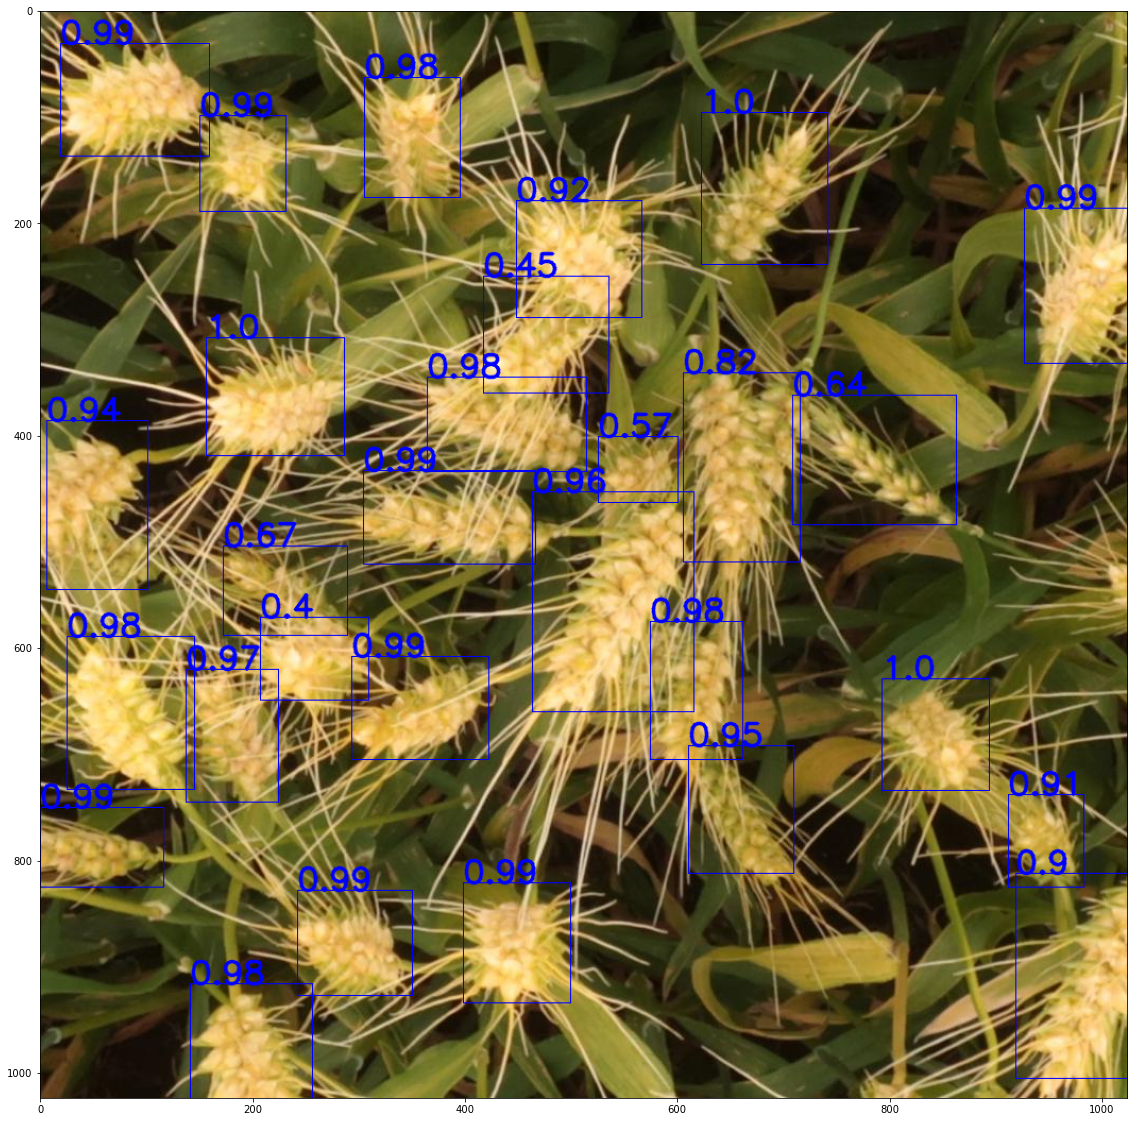

In [9]:
from matplotlib import pyplot as plt
image = im.copy()
size = 300
font = cv2.FONT_HERSHEY_SIMPLEX 
    
# fontScale 
fontScale = 1
   
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2
for b,s in zip(boxes,scores):
    image = cv2.rectangle(image, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), (255,0,0), 1) 
    image = cv2.putText(image, '{:.2}'.format(s), (b[0],b[1]), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
plt.figure(figsize=[20,20])
plt.imshow(image[:,:,::-1])
plt.show()

In [10]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)